In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

# Домашнее задание №7: деревья, случайный лес (14.5 баллов)

## Часть 1: основы построения решающие дерева

начнём с простого...

### Задание 1.1 (1 балл)
Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 - $k_2$. Посчитайте энтропию (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [2]:
import numpy as np

def entropy(p):
    """
    p <- вектор вероятностей. i-ый элемент вектора - вероятность i-ого события
    """
    return -1 * sum(p * np.log(p))


print(np.round(entropy(np.array([8 / 10, 2 / 10])), 2), '<- энтропия разбиения')

0.5 <- энтропия разбиения


### Задание 1.2 (1 балл)
Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности (в формулировке разности impurity пришедшей выборки и полученного разбиения) такой вершины с применением индекса Джини. Ответ округлите до двух знаков после запятой.

In [3]:
def impurity(old, left, right):
    """
    old, left, right <- 3 вектора с вероятностями
    """
    
    return gini(old) - old[0] * gini(left) - old[1] * gini(right)

def gini(p):
    """
    p <- вектор вероятностей. i-ый элемент вектора - вероятность i-ого события
    """
    
    return sum(p * (1 - p))

old = np.array([.8, .2])
left = np.array([1, 0])
right = np.array([1, 0])
print(impurity(old, left, right), '<- Информационный прирост после разбиения')

0.32 <- Информационный прирост после разбиения


### Задание 1.3 (0.5 балла)
Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [4]:
leaf = np.array([1, 10, 5, 18, 100, 30, 50, 61, 84, 47])
print(leaf.mean(), '<- Предсказание в ветке при использовании константного прогноза = среднее по обучающей \
выборке в листе')


40.6 <- Предсказание в ветке при использовании константного прогноза = среднее по обучающей выборке в листе


## Часть 2: решающие деревья

### Задание 2.1 (2 балла)
Первым делом реализуйте функцию `find_best_split`, которая должна находить оптимальное разбиение подмножества обучающей выборки. При решении задачи регрессии испольуйте дисперсию подвыборки, при решении задачи классификации используйте критерий Джини. Эту функцию можно протестировать на датасете `Boston` из `sklearn`.

In [5]:
from collections import Counter
from typing import Dict, List, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston

In [6]:
boston = load_boston()
X = pd.DataFrame(data=boston["data"], columns=boston["feature_names"])
y = boston["target"]
X.head()

# print(boston["DESCR"])

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


При решении задания имейте в виду, что под критерием Джини подразумевается такая функция:

$$Q(R) = -\frac {|R_{\ell}|}{|R|}H(R_\ell) -\frac {|R_r|}{|R|}H(R_r) ,$$

где $R$ — множество объектов, попавших в вершину, $R_{\ell}$ и $R_r$ — объекты, попавшие в левое и правое поддеревья,
$H(R) = 1 - p_1^2 - p_0^2$, $p_1$, $p_0$ — доли объектов класса 1 и 0 соответственно.

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям (скачайте решённую версию ноутбука).

**Note:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла бонус 0.7 балла

In [7]:
# Вспомогательные функции

def informational_criterion(left_targets, right_targets, task='classification'):
    """
    Считаем информационный критерий для заданного разбиения
    """
    left_node_size = left_targets.shape[0]
    right_node_size = right_targets.shape[0]
    current_node_size = left_node_size + right_node_size
    
    if task == 'classification':  # Считаем критерий по Джини для задач классификации
        
        left_probs = np.array([left_targets[left_targets == 0].shape[0] / left_targets.shape[0], left_targets[left_targets == 1].shape[0] / left_targets.shape[0]])
        right_probs = np.array([right_targets[right_targets == 0].shape[0] / right_targets.shape[0], right_targets[right_targets == 1].shape[0] / right_targets.shape[0]])
        
        return -left_node_size / (left_node_size + right_node_size) * gini(left_probs) -right_node_size / (left_node_size + right_node_size) * gini(right_probs)
    
    else:  # Считаем критерий по дисперсию для задач регрессии
        return -1 * (left_node_size * (left_targets.std() ** 2) / current_node_size + right_node_size * (right_targets.std() ** 2) / current_node_size)
        
        
        
def split_current_node(threshold, features, targets, feature_type, task):
    """
    На вход идет порог, признаки, целевые переменные, тип признака и характер задачи
    Функция делает разбиение. 
    Считает инф критерий и возвращает его
    """
    if feature_type == 'real':
        left_mask, right_mask = features <= threshold, features > threshold
        left_targets, right_targets = targets[left_mask], targets[right_mask]
    else:  # categorical feature
        left_mask, right_mask = features == threshold, features != threshold
        left_targets, right_targets = targets[left_mask], targets[right_mask]

    return informational_criterion(left_targets, right_targets, task)

split_current_node_vectorized = np.vectorize(split_current_node, excluded=['features', 'targets', 'feature_type', 'task'], signature='(),(n),(n),(),()->()')
# Сигнатура: 1 аргумент - число, тк векторизируем относительно порога. 2 и 3 аргументы - векторы признака и таргета. Далее два скалярных аргумента - название задачи и тип признака
# На вход у нас идут пороги и "постоянные" параметры. 
# То есть для разбиения заданного признака у нас вектор признаков, вектор целевых переменных, task и тип признака не меняются. Мы хотим векторизировать лишь обход порогов. 

def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame], 
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`
    
    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    # Сначала найдем пороги
    unique_features = np.unique(feature_vector)
    if unique_features.shape[0] == 1:
        return unique_features, np.array([-np.inf]), unique_features[0], -np.inf
    if feature_type == 'real':
        unique_features = np.unique(feature_vector)
        thresholds = (unique_features[1:] + unique_features[:-1]) / 2  # Нашли пороги. Тк взяли только уникальные значения признаков, то пустых веток гарантированно не будет.
    else:  # То есть признак у нас категориальный
        thresholds = np.unique(feature_vector)
        
    
    # Теперь, имея пороги, можем для каждого порога посчитать качество его разбиения
    critetions = split_current_node_vectorized(thresholds, feature_vector, target_vector, feature_type, task)  # Вектор инф. критериев для каждого порога
    best_index = np.lexsort((thresholds, critetions))[-1]  # Тут порядок обратный - сначала сортируем по критерию, а уже потом по порогу. Сортировка идет по-возрастанию. 
    
    return thresholds, critetions, thresholds[best_index], critetions[best_index]

thresholds, variances, threshold_best, variance_best = find_best_split(
    X["CRIM"].to_numpy(), 
    y, 
    task="regression",
    feature_type="real"
)

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `CRIM` **(наш)**.

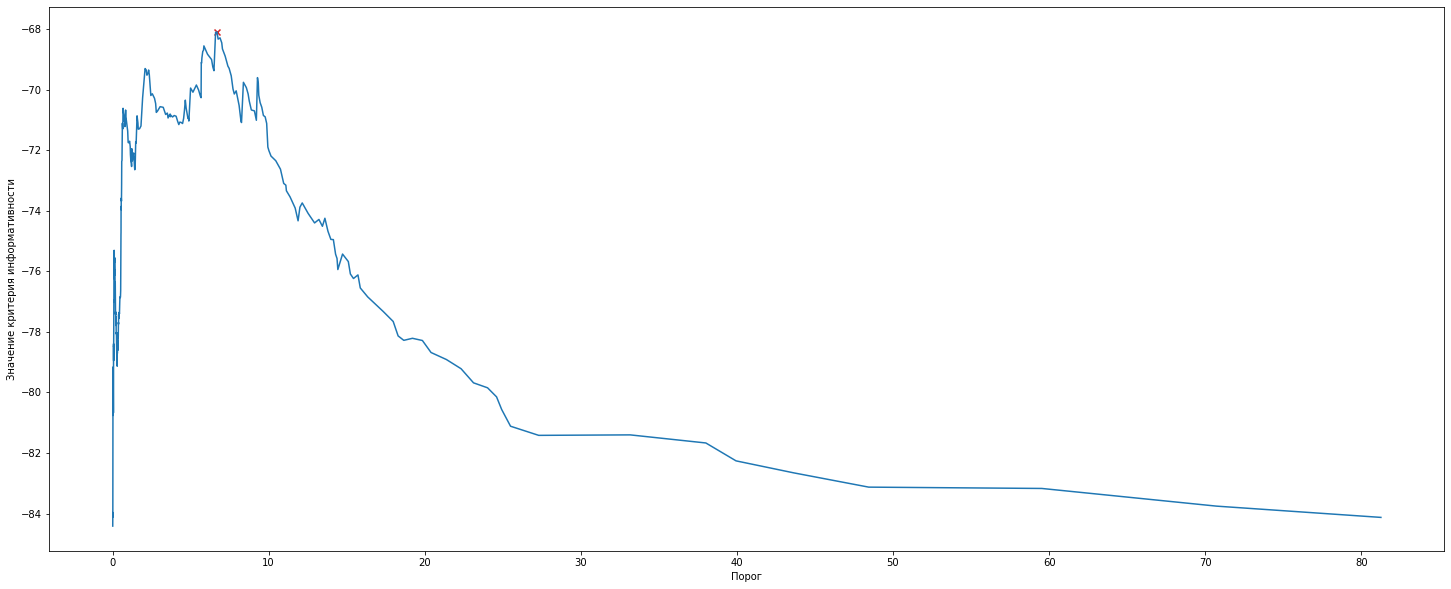

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(25, 10))
ax.plot(thresholds, variances, color='tab:blue')
ax.scatter([threshold_best], [variance_best], color='tab:red', marker='x')
ax.set_xlabel('Порог')
ax.set_ylabel('Значение критерия информативности');

### Задание 2.2 (3 балла)
Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод _predict_node.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- Выбор лучшего разбиения необходимо производить по критерию Джини
- Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку
- Ответ в листе: наиболее часто встречающийся класс в листе

In [9]:
class DecisionTree:
    def __init__(
        self, 
        feature_types: Union[List[str], np.ndarray], 
        max_depth: int = None, 
        min_samples_split: int = None, 
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:
        
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}
        
        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types
        
        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task

    def _fit_node(
        self, 
        sub_X: np.ndarray, 
        sub_y: np.ndarray, 
        node: dict
    ) -> None:
        
        # критерий останова
        if np.all(sub_y == sub_y[0]):  # Для всех объектов вектора sub_y справедливо, что они равны sub_y[0] - то есть первому элементу
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]
                
            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)
            
            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = feature_vector <= threshold
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    split = feature_vector == threshold
                else:
                    raise ValueError

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError
            
        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        if node['type'] == 'nonterminal':
            considered_feature = x[node['feature_split']]
            
            if 'threshold' in node.keys():
                if considered_feature <= node['threshold']:
                    return self._predict_node(x, node['left_child'])
                else:
                    return self._predict_node(x, node['right_child'])
            
            elif considered_feature == node['category_split']:
                return self._predict_node(x, node['left_child'])
            else:
                return self._predict_node(x, node['right_child'])
            
        else:
#             print(f'Inside the tree for {x} with {node["class"]}')
            prediction = node['class']
#             print(f'Will predict this: {prediction}')
            return prediction
        
    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
#             print(f'Just before the tree for {x}')
            predicted.append(self._predict_node(x, self._tree))
#             print(f'Got this out: {predicted[-1]}\n\n\n')
            
        return np.array(predicted)

### Задание 2.3 (1 балл)
Загрузите таблицу [students.csv](https://drive.google.com/file/d/0B2zoFVYw1rN3a0d0Zm43TzQ4aUU/view?usp=sharing) (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака — класс" для всех пяти признаков.

In [10]:
students_df = pd.read_csv('students.csv')
students_X, students_y = students_df[['STG', 'SCG', 'STR', 'LPR', 'PEG']].to_numpy(), students_df[' UNS'].to_numpy()

feature_stats = dict()
for i in range(students_X.shape[1]):
    feature_vec = students_X[:, i]
    feature_stats[i] = find_best_split(feature_vec, students_y)

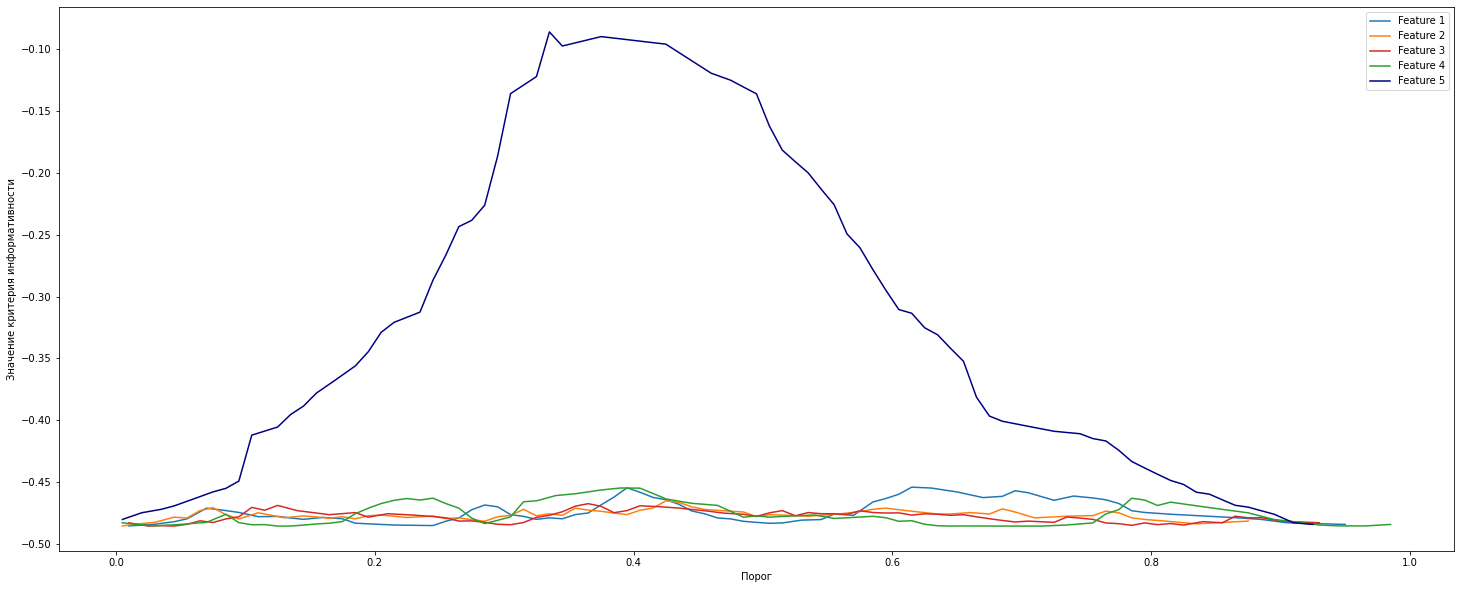

In [11]:
fig, ax = plt.subplots(figsize=(25, 10))
ax.plot(feature_stats[0][0], feature_stats[0][1], color='tab:blue', label='Feature 1')
ax.plot(feature_stats[1][0], feature_stats[1][1], color='tab:orange', label='Feature 2')
ax.plot(feature_stats[2][0], feature_stats[2][1], color='tab:red', label='Feature 3')
ax.plot(feature_stats[3][0], feature_stats[3][1], color='tab:green', label='Feature 4')
ax.plot(feature_stats[4][0], feature_stats[4][1], color='navy', label='Feature 5')

ax.set_xlabel('Порог')
ax.set_ylabel('Значение критерия информативности')
ax.legend();

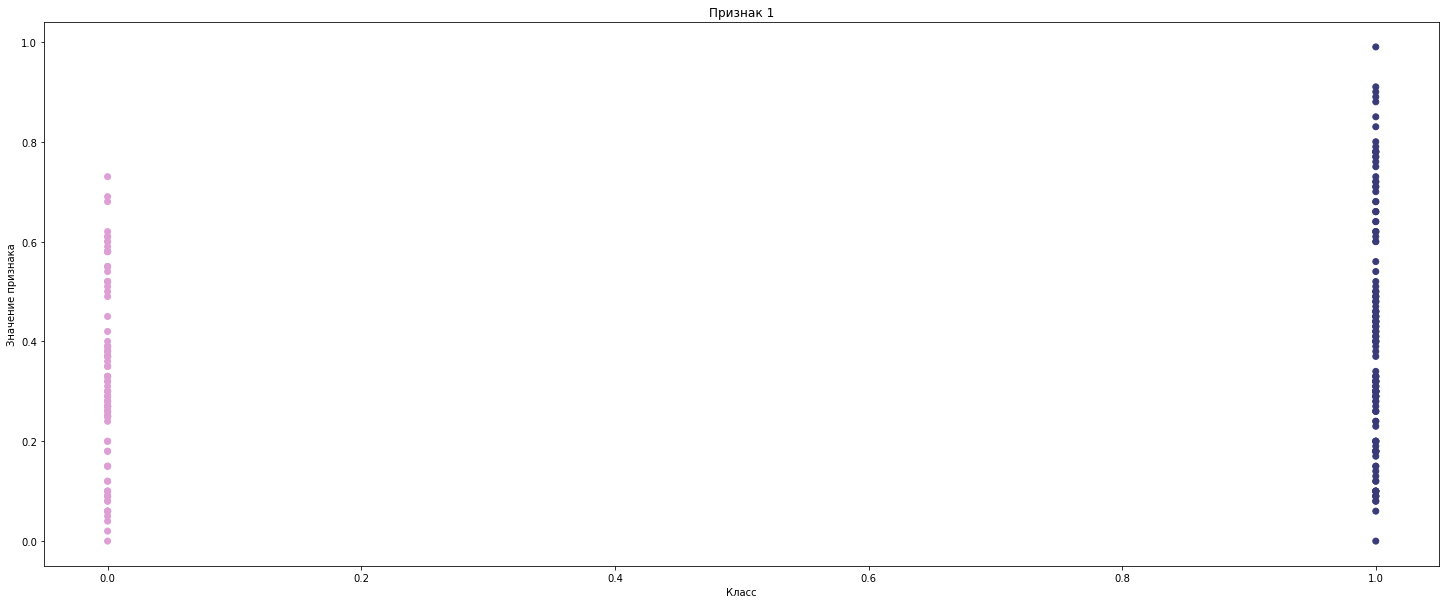

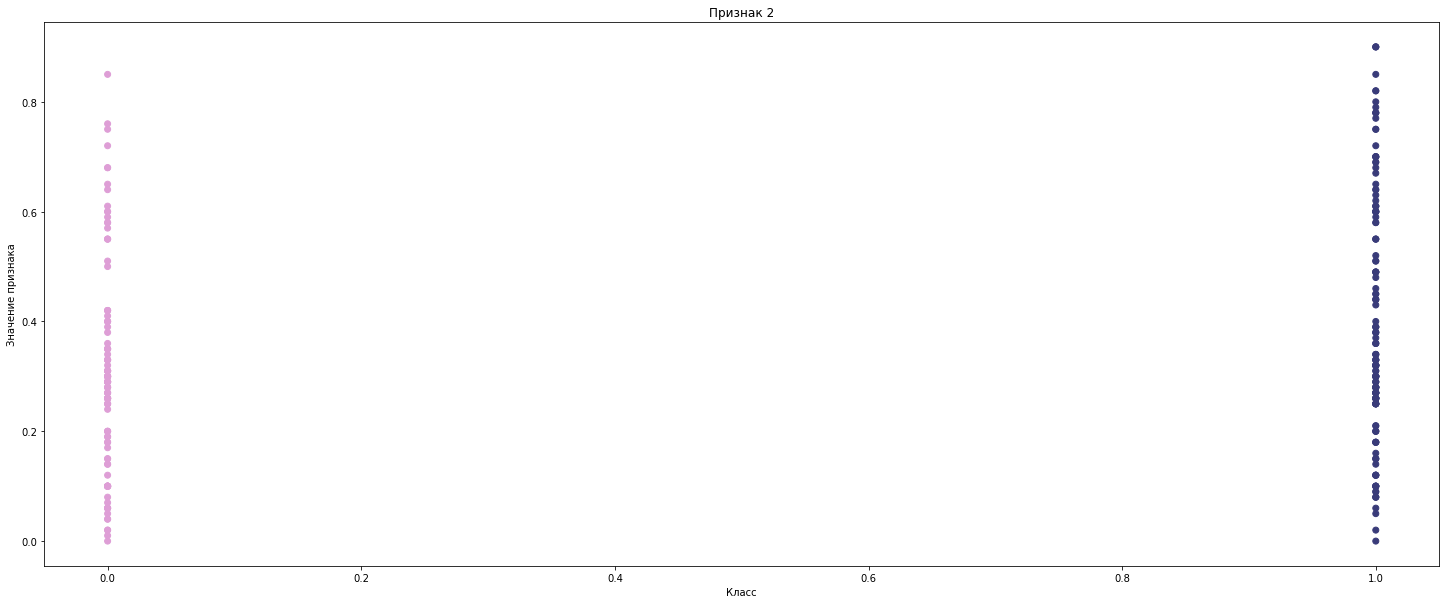

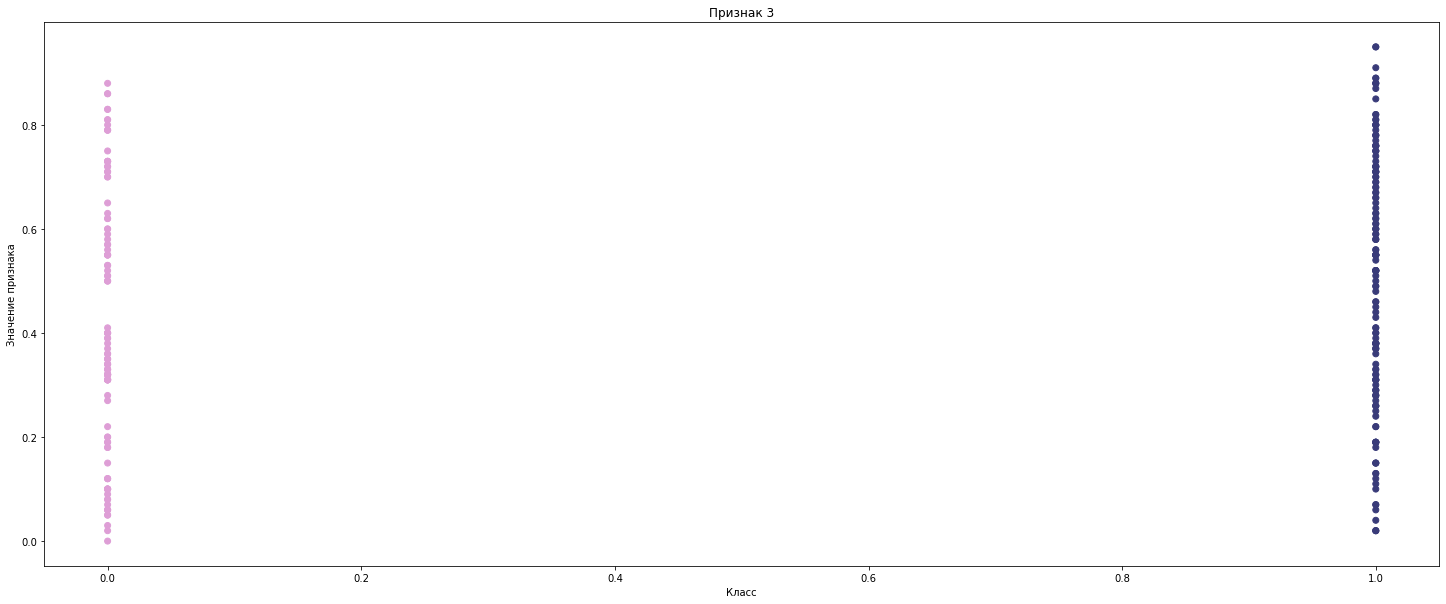

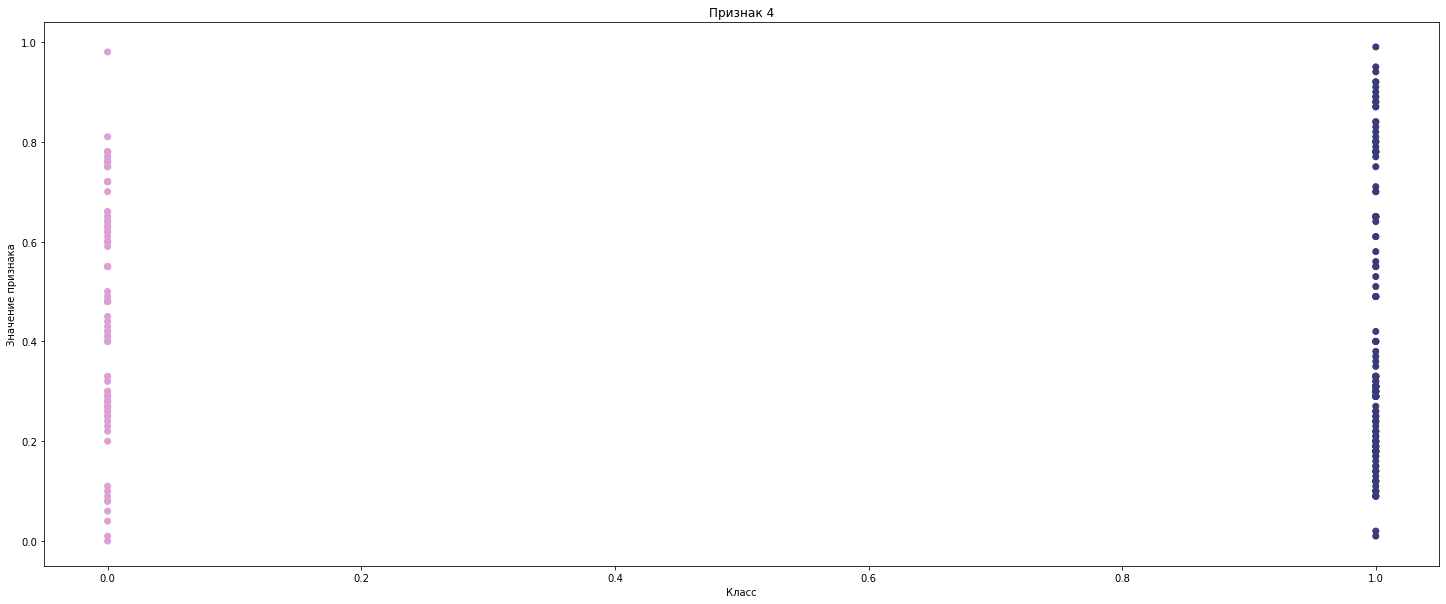

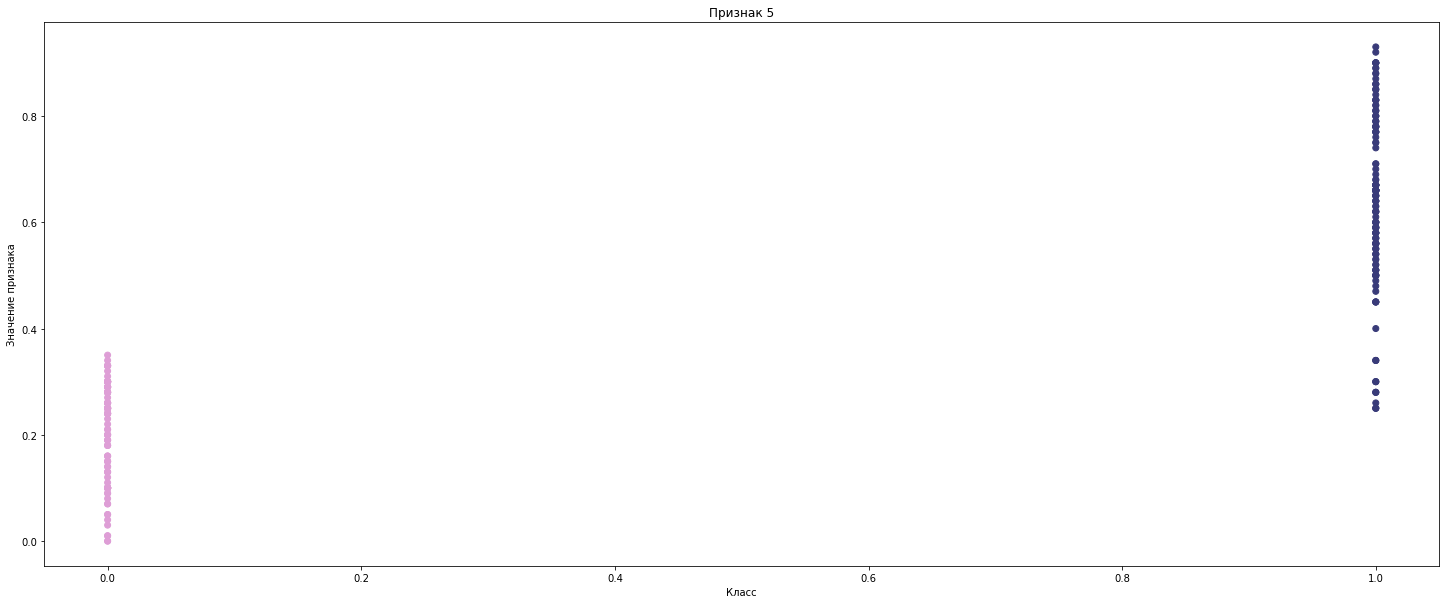

In [12]:
fig, ax = plt.subplots(figsize=(25, 10))
ax.scatter(y=students_X[:, 0], x=students_y, c=students_y, cmap='tab20b_r')

ax.set_title('Признак 1')
ax.set_xlabel('Класс')
ax.set_ylabel('Значение признака');


fig, ax = plt.subplots(figsize=(25, 10))
ax.scatter(y=students_X[:, 1], x=students_y, c=students_y, cmap='tab20b_r')

ax.set_title('Признак 2')
ax.set_xlabel('Класс')
ax.set_ylabel('Значение признака');


fig, ax = plt.subplots(figsize=(25, 10))
ax.scatter(y=students_X[:, 2], x=students_y, c=students_y, cmap='tab20b_r')

ax.set_title('Признак 3')
ax.set_xlabel('Класс')
ax.set_ylabel('Значение признака');


fig, ax = plt.subplots(figsize=(25, 10))
ax.scatter(y=students_X[:, 3], x=students_y, c=students_y, cmap='tab20b_r')

ax.set_title('Признак 4')
ax.set_xlabel('Класс')
ax.set_ylabel('Значение признака');


fig, ax = plt.subplots(figsize=(25, 10))
ax.scatter(y=students_X[:, 4], x=students_y, c=students_y, cmap='tab20b_r')

ax.set_title('Признак 5')
ax.set_xlabel('Класс')
ax.set_ylabel('Значение признака');

### Задание 2.4 (1 балл)

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

### Ответ:
Согласно графикам по критериям информативности делить надо по **5 признаку**. <br>Это, кстати, видно и по облаку точек для 5 признака. <br>Там заметно, что признак принимает разные промежутки значений для разных классов. 

### Задание 2.5 (1 балл)

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [13]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns', None)
labelencoder = LabelEncoder()

In [14]:
mushrooms = pd.read_csv('agaricus-lepiota.data', header=None)
mushrooms[0] = mushrooms[0].apply(lambda x: 1 if x == 'p' else 0)
m_y = mushrooms[0].values
mushrooms.drop(columns=[0], inplace=True)
m_X = mushrooms.apply(labelencoder.fit_transform, axis=0).to_numpy()
m_X_train, m_X_test, m_y_train, m_y_test = train_test_split(m_X, m_y, test_size=.5, random_state=21, shuffle=True)

DTree = DecisionTree(['categorical' for x in range(m_X.shape[1])])
DTree.fit(m_X_train, m_y_train)
m_y_hat = DTree.predict(m_X_test)
print(f'{(m_y_hat == m_y_test).mean()} <- accuracy here')

1.0 <- accuracy here


## Часть 3: бэггинг, случайный лес

В данной части будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [15]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [16]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

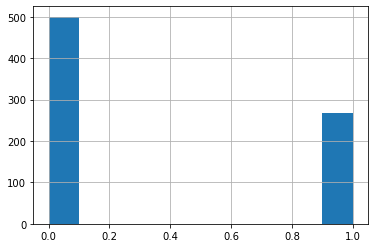

In [17]:
data['Outcome'].hist()
plt.show()

Разделите данные на признаки и целевую переменную. Разбейте датасет на тренировочную и тестовую части в отношении 70:30.

In [18]:
y = data['Outcome'].values
X = data.drop(columns=['Outcome']).to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=7, shuffle=True)

### Задание 3.1 (1 балл)

Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [19]:
bag_clf = BaggingClassifier(n_estimators=50)
bag_clf.fit(X_train, y_train)
y_hat_bag = bag_clf.predict(X_test)

print(f'{precision_score(y_test, y_hat_bag)} <- precision')
print(f'{accuracy_score(y_test, y_hat_bag)} <- accuracy')
print(f'{recall_score(y_test, y_hat_bag)} <- recall')
print(f'{roc_auc_score(y_test, y_hat_bag)} <- AUC ROC')

0.6626506024096386 <- precision
0.7532467532467533 <- accuracy
0.6547619047619048 <- recall
0.7321428571428571 <- AUC ROC


### Задание 3.2 (1 балл)

Теперь обучите Random Forest с таким же количеством деревьев. Оцените качество классификации по тем же метрикам. Какая из двух построенных моделей показала себя лучше?

In [20]:
rf_clf = RandomForestClassifier(n_estimators=50)
rf_clf.fit(X_train, y_train)
y_hat_rf = rf_clf.predict(X_test)

print(f'{precision_score(y_test, y_hat_rf)} <- precision')
print(f'{accuracy_score(y_test, y_hat_rf)} <- accuracy')
print(f'{recall_score(y_test, y_hat_rf)} <- recall')
print(f'{roc_auc_score(y_test, y_hat_rf)} <- AUC ROC')

0.6521739130434783 <- precision
0.7272727272727273 <- accuracy
0.5357142857142857 <- recall
0.6862244897959183 <- AUC ROC


*Видно, что случайный лес не уступает / лучше по всем метрикам кроме полноты.*

### Задание 3.3 (1 балл)

Для случайного леса проанализируйте значение AUC-ROC на этих же данных в зависимости от изменения параметров (можете сделать обычный перебор с обучением/тестированием в цикле):
* `'n_estimators'` (можно перебрать около 10 значений из отрезка от 10 до 1500)
* `'min_samples_leaf'` (сетку значений можете выбрать на ваше усмотрение)

Постройте соответствующие графики зависимости AUC-ROC от этих параметров. Используйте heat map для визуализации. Какие выводы вы можете сделать?

n_estims = 10 and min_samples_leaf = 2

0.7142857142857144 <- AUC ROC



n_estims = 10 and min_samples_leaf = 3

0.7023809523809524 <- AUC ROC



n_estims = 10 and min_samples_leaf = 4

0.7287414965986395 <- AUC ROC



n_estims = 250 and min_samples_leaf = 2

0.7525510204081632 <- AUC ROC



n_estims = 250 and min_samples_leaf = 3

0.7287414965986395 <- AUC ROC



n_estims = 250 and min_samples_leaf = 4

0.7261904761904763 <- AUC ROC



n_estims = 500 and min_samples_leaf = 2

0.7397959183673469 <- AUC ROC



n_estims = 500 and min_samples_leaf = 3

0.7304421768707483 <- AUC ROC



n_estims = 500 and min_samples_leaf = 4

0.7287414965986395 <- AUC ROC



n_estims = 800 and min_samples_leaf = 2

0.7465986394557823 <- AUC ROC



n_estims = 800 and min_samples_leaf = 3

0.7406462585034014 <- AUC ROC



n_estims = 800 and min_samples_leaf = 4

0.7397959183673469 <- AUC ROC



n_estims = 1000 and min_samples_leaf = 2

0.7465986394557823 <- AUC ROC



n_estims = 1000 and min_samples_leaf = 3

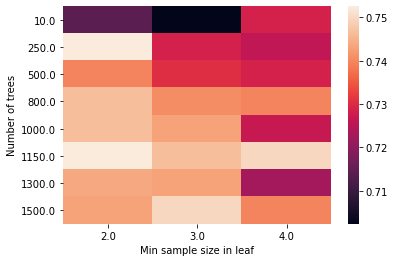

In [21]:
stats = None

for num_trees in [10, 250, 500, 800, 1000, 1150, 1300, 1500]:
    for min_leaf_size in [2, 3, 4]:

        rf_clf = RandomForestClassifier(n_estimators=num_trees, min_samples_leaf=min_leaf_size)
        rf_clf.fit(X_train, y_train)
        y_hat_rf = rf_clf.predict(X_test)
        rocauc = roc_auc_score(y_test, y_hat_rf)
        if stats is None:
            stats = np.array([num_trees, min_leaf_size, rocauc])
        else:
            stats = np.vstack((stats, np.array([num_trees, min_leaf_size, rocauc])))
        
        print(f'n_estims = {num_trees} and min_samples_leaf = {min_leaf_size}\n')
        print(f'{rocauc} <- AUC ROC\n\n\n')
        
stats_df = pd.DataFrame(data=stats, columns=['Number of trees', 'Min sample size in leaf', 'ROC AUC score'])
stats_df = stats_df.pivot('Number of trees', 'Min sample size in leaf', 'ROC AUC score')

import seaborn as sns
sns.heatmap(data=stats_df)

***Выводы: большое число деревьев не переобучает алгоритм. У нас оптимум вышел с разрешенным минимальным числом объектов в листе = 2, что, кажется, совсем немного, но тем не менее.***

### Задание 3.4 (1 балл)

Для лучшей модели случайного леса посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

In [22]:
best_clf = RandomForestClassifier(n_estimators=1500, min_samples_leaf=2)
best_clf.fit(X_train, y_train)
y_hat = best_clf.predict(X_test)

# Обучили модель
# Посчитаем основные метрики

b_prec = precision_score(y_test, y_hat)
b_acc = accuracy_score(y_test, y_hat)
b_rec = recall_score(y_test, y_hat)
b_ra = roc_auc_score(y_test, y_hat)

In [23]:
for column_num in range(X_test.shape[1]):
    
    indexes = np.arange(X_test.shape[0])
    np.random.shuffle(indexes)
    X_test_distorted = X_test.copy()
    X_test_distorted[:, column_num] = X_test[:, column_num][indexes]
    y_hat_distorted = best_clf.predict(X_test_distorted)
    
    distorted_prec = precision_score(y_test, y_hat_distorted)
    distorted_acc = accuracy_score(y_test, y_hat_distorted)
    distorted_rec = recall_score(y_test, y_hat_distorted)
    distorted_ra = roc_auc_score(y_test, y_hat_distorted)
    
    print(f'Distorted features number is {column_num}')
    print(b_acc - distorted_acc, '<- Accuracy')
    print(b_prec - distorted_prec, '<- Precision')
    print(b_rec - distorted_rec, '<- Recall')
    print(b_ra - distorted_ra, '<- ROC AUC\n\n\n')

Distorted features number is 0
0.03463203463203468 <- Accuracy
0.05263157894736836 <- Precision
0.04761904761904756 <- Recall
0.03741496598639449 <- ROC AUC



Distorted features number is 1
0.09090909090909094 <- Accuracy
0.13020424194815394 <- Precision
0.17857142857142855 <- Recall
0.10969387755102045 <- ROC AUC



Distorted features number is 2
0.017316017316017396 <- Accuracy
0.02169274537695587 <- Precision
0.0357142857142857 <- Recall
0.021258503401360485 <- ROC AUC



Distorted features number is 3
-0.008658008658008587 <- Accuracy
-0.018847795163584702 <- Precision
0.0 <- Recall
-0.006802721088435382 <- ROC AUC



Distorted features number is 4
0.02164502164502169 <- Accuracy
0.030701754385964897 <- Precision
0.0357142857142857 <- Recall
0.024659863945578175 <- ROC AUC



Distorted features number is 5
0.04329004329004338 <- Accuracy
0.06578947368421051 <- Precision
0.059523809523809534 <- Recall
0.04676870748299322 <- ROC AUC



Distorted features number is 6
0.02164502164502

**Если за главную метрику качества взять Recall (важно выявлять всех с диабетом, пусть и мб с не супер высокой точностью), то:**<br>
Важнее всего для модели окажется признак №2 или колонка №0